In [1]:
import detailed_kf_bugtesting as dkf
import kf_standard_bugtesting as skf

from ML_Kalman import Kalman

In [2]:
import numpy as np

########################
# File Data
########################
filename0_ = 'buggy'
savetopath_ = './'

########################
# Bayes Risk Parameters
########################
max_it_BR_ = 2
num_randparams_ = 10
space_size_ = np.arange(-8,3)
truncation_ =20
bayes_params_ = [max_it_BR_, num_randparams_, space_size_,truncation_]

########################
# Experiment Parameters
########################
n_train_ = 2000
n_predict_ = 48
n_testbefore_ = 49
multiplier_ = 20.0 
bandwidth_ = 50.0

exp_params_ = [n_train_, n_predict_, n_testbefore_, multiplier_, bandwidth_]

########################
# Truth Parameters
########################
apriori_f_mean_ = 0.0 
alpha_ = 1.0
f0_ = 10.0
p_ = -1 #1 #-2 #-1 #0.0
J_ = 2
jstart_ = 1 # (not zero)
pdf_type_u_ = 'Uniform'
      
true_noise_params_ = [apriori_f_mean_, pdf_type_u_, alpha_, f0_, p_, J_, jstart_]

########################
# Measurement Noise 
########################
msmt_noise_mean_ = 0.0 
msmt_noise_level_ = 0.01 

msmt_noise_params_ = [msmt_noise_mean_, msmt_noise_level_]

########################
# Kalman Parameters
########################
p0_ = 10000.0 
x0_ = 1.0
optimal_sigma_ = 0.1
optimal_R_ = 0.1
b_delta_ = 0.5 

max_it_ = 5

kalman_params_ = [optimal_sigma_, optimal_R_, x0_, p0_, b_delta_]

########################
# Skip Msmts
########################
skip =1


In [3]:
from ML_Kalman import Kalman

Test_Object = Kalman(filename0_, savetopath_, max_it_,
                     exp_params_, kalman_params_, msmt_noise_params_,
                     true_noise_params_, user_defined_variance=None, 
                     skip_msmts=skip)

First, recreate the error using the base code:

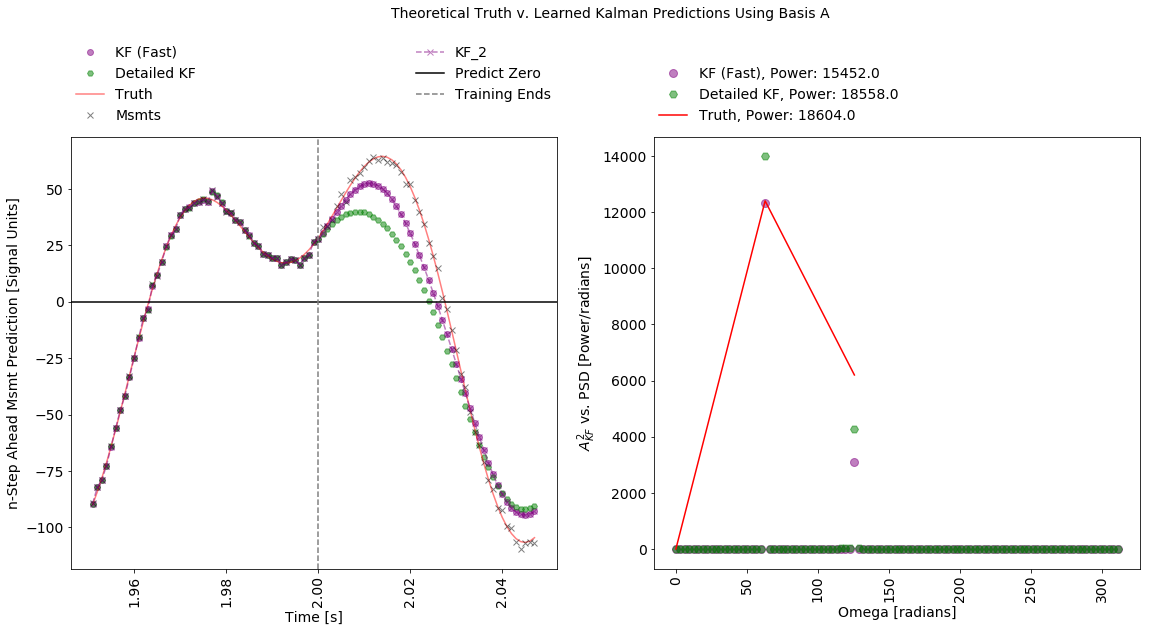

In [4]:
Test_Object.run_test_KF()

Let's plot the relevant trajectories for the intervals (0,220), (400,620), and (1800,2020). This will characterise that the state estimates start off identically, and then diverge:

In [37]:
dkf_data_object = np.load('buggy_kfresults_det_KF_.npz')
skf_data_object = np.load('Check_KF_Results.npz')

(200, 1, 2048) <numpy.lib.npyio.NpzFile object at 0x7f5adc426750> x_hat
(200, 1, 2048) <numpy.lib.npyio.NpzFile object at 0x7f5adc42f090> x_hat


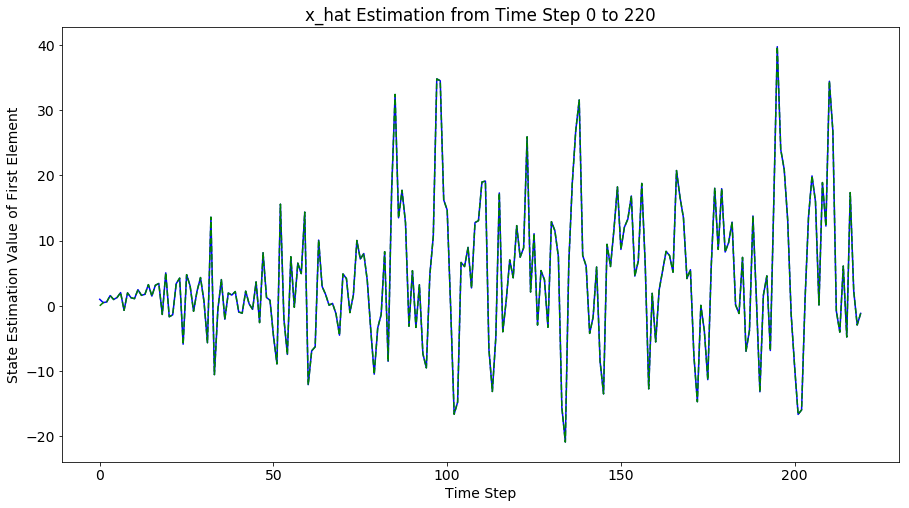

(200, 1, 2048) <numpy.lib.npyio.NpzFile object at 0x7f5adc426750> x_hat
(200, 1, 2048) <numpy.lib.npyio.NpzFile object at 0x7f5adc42f090> x_hat


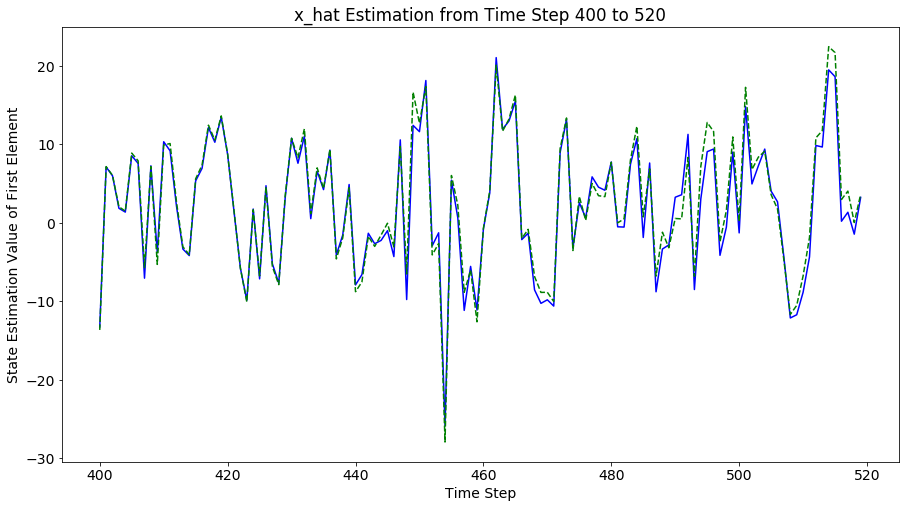

(200, 1, 2048) <numpy.lib.npyio.NpzFile object at 0x7f5adc426750> x_hat
(200, 1, 2048) <numpy.lib.npyio.NpzFile object at 0x7f5adc42f090> x_hat


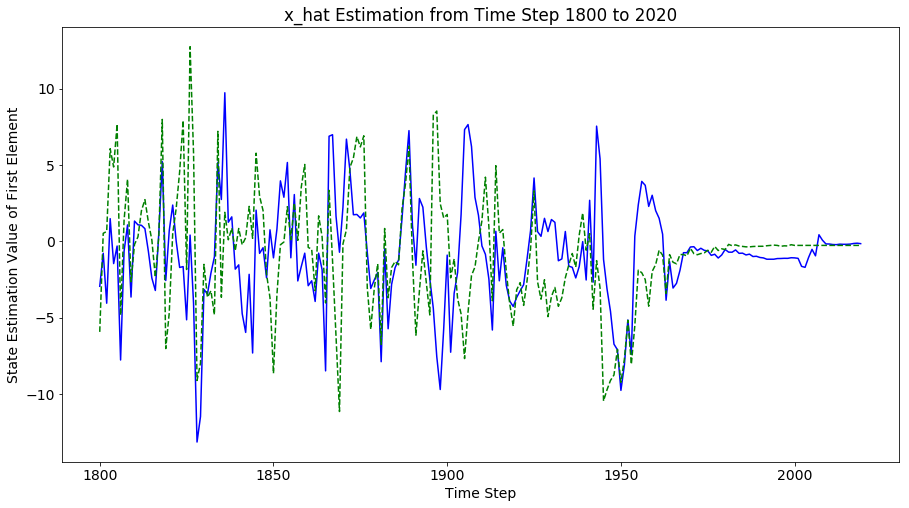

In [39]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['font.size']= 14

list_ = [dkf_data_object, skf_data_object]
var_ = ['x_hat']
color = ['b', 'g--']


time_start = 0
time_end = 220

for item in var_:
    plt.figure(figsize=(15,8))
    plt.title('%s Estimation from Time Step %s to %s' %(item, time_start, time_end))
    plt.xlabel('Time Step')
    plt.ylabel('State Estimation Value of First Element')
    i =0
    for obj in list_:
        print obj[item].shape, obj, item
        x_data = obj[item][0,0,time_start:time_end]
        plt.plot(range(time_start, time_end, 1), x_data, color[i])
        i=+1
plt.show()

time_start = 400
time_end = 520

for item in var_:
    plt.figure(figsize=(15,8))
    plt.title('%s Estimation from Time Step %s to %s' %(item, time_start, time_end))
    plt.xlabel('Time Step')
    plt.ylabel('State Estimation Value of First Element')
    i =0
    for obj in list_:
        print obj[item].shape, obj, item
        x_data = obj[item][0,0,time_start:time_end]
        plt.plot(range(time_start, time_end, 1), x_data, color[i])
        i=+1
plt.show()

time_start = 1800
time_end = 2020
for item in var_:
    plt.figure(figsize=(15,8))
    plt.title('%s Estimation from Time Step %s to %s' %(item, time_start, time_end))
    plt.xlabel('Time Step')
    plt.ylabel('State Estimation Value of First Element')
    i =0
    for obj in list_:
        print obj[item].shape, obj, item
        x_data = obj[item][0,0,time_start:time_end]
        plt.plot(range(time_start, time_end, 1), x_data, color[i])
        i=+1
plt.show()